In [212]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats

In [213]:
# Read data file

df = pd.read_excel('/Users/jinhyun/Documents/GitHub/Python/assignment/assignmentsmodelvalidatortradingriskmodelsating/2. CCR FXselected.xlsx') # imports the data
display(df)

,DATE,EURUSD
0,2018-08-01 23:59:59,1.16715
1,2018-07-31 23:59:59,1.16985
2,2018-07-30 23:59:59,1.17120
3,2018-07-27 23:59:59,1.16545
4,2018-07-26 23:59:59,1.16620
...,...,...
2604,2008-08-07 23:59:59,1.53770
2605,2008-08-06 23:59:59,1.54215
2606,2008-08-05 23:59:59,1.54870
2607,2008-08-04 23:59:59,1.56130


In [214]:
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y-%m-%d') # transform date strings to datetime 
df = df.set_index(['DATE']) # set index of DataFrame to the date column
df['R_log'] = np.log(df[['EURUSD']]) - np.log(df[['EURUSD']]).shift(1) # calculate log returns
df = df.dropna()
display(df)

,EURUSD,R_log
DATE,,
2018-07-31 23:59:59,1.16985,0.002311
2018-07-30 23:59:59,1.17120,0.001153
2018-07-27 23:59:59,1.16545,-0.004922
2018-07-26 23:59:59,1.16620,0.000643
2018-07-25 23:59:59,1.16740,0.001028
...,...,...
2008-08-07 23:59:59,1.53770,0.022559
2008-08-06 23:59:59,1.54215,0.002890
2008-08-05 23:59:59,1.54870,0.004238


Task 1: Calibration: 

1)	Derive the closed-form formulas of the 97.5 and 2.5 quantiles of the log-returns of the GBM model.

In [215]:
df = df[(np.abs(stats.zscore(df)) < stats.norm.ppf(0.975)).all(axis=1)] # match the 97.5th and 2.5th quantiles 
display(df)

,EURUSD,R_log
DATE,,
2018-07-31 23:59:59,1.16985,0.002311
2018-07-30 23:59:59,1.17120,0.001153
2018-07-27 23:59:59,1.16545,-0.004922
2018-07-26 23:59:59,1.16620,0.000643
2018-07-25 23:59:59,1.16740,0.001028
...,...,...
2008-08-18 23:59:59,1.47015,-0.000068
2008-08-15 23:59:59,1.46925,-0.000612
2008-08-13 23:59:59,1.48710,-0.001915


2) Derive μ and σ as a function of these quantiles from the formulas in 1)

In [216]:
u = df['EURUSD'].mean()
sigma = df['EURUSD'].std()
print(u,sigma)

1.265803921568628 0.11892939355237946


3. Calibrate μ and σ using the time series data and formula from 2)

4. In step 3) we have calibrated the parameters calibrated from daily log-returns. However, in the simulation step, we want to simulate the FX spot rate on a weekly simulation grid instead of daily. So, please calculate the corresponding μ_weekly and σ_weekly , from μ_daily and σ_daily  derived in step 3), assuming 1 week = 5 days.

In [217]:
df['mean_w'] = df['R_log'].rolling(5).mean()
df['std_w']  = df['R_log'].rolling(5).std()
df = df.dropna()
display(df)

,EURUSD,R_log,mean_w,std_w
DATE,,,,
2018-07-25 23:59:59,1.16740,0.001028,0.000043,0.002844
2018-07-24 23:59:59,1.17050,0.002652,0.000111,0.002915
2018-07-23 23:59:59,1.17040,-0.000085,-0.000137,0.002857
2018-07-20 23:59:59,1.17065,0.000214,0.000890,0.001072
2018-07-19 23:59:59,1.16140,-0.007933,-0.000825,0.004113
...,...,...,...,...
2008-08-18 23:59:59,1.47015,-0.000068,-0.001052,0.005762
2008-08-15 23:59:59,1.46925,-0.000612,-0.001661,0.005454
2008-08-13 23:59:59,1.48710,-0.001915,-0.002959,0.004233


# 2. Simulation 

1)	Test whether the daily log-returns of the underlying FX rate follows a normal distribution using any of the normality test methodologies and explain the testing results. 

In [218]:
print('SMI :', stats.jarque_bera(df["R_log"]))

SMI : Jarque_beraResult(statistic=2.2658235212548883, pvalue=0.3220940289711951)


Jarque-Bera test is designed to test the normality (goodness of fit test). The test statistic for JB test with p = 99.5% is 10.597.

The actual result of the DAX return is larger than JB test statistic. (2.266 <> 10.597)
The p values from two types of returns are not significant (p < 0.01)

Therefore we can conclude that the assumption of normally distributed reuturn is valid with 99.5% level

2)	Simulate 1000 independent scenarios, with S(0) equal to the latest FX rate in the time series data, t=1week, 2week,……50weeks, and use parameters derived in calibration step 4). In this step we generate S(t) for each simulation path and at each simulation time point.

In [219]:
def gen_paths(S0, r, sigma, T, M, I):
    """
    GBM-path generating function from Yves Hilpisch
    """
    dt = float(T) / M
    paths = np.zeros((M + 1, I), np.float64)
    paths[0] = S0
    for t in range(1, M + 1):
        rand = np.random.standard_normal(I)
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt +
                                         sigma * np.sqrt(dt) * rand)
    return paths

In [220]:
# Setting initial values 

S0 = df['EURUSD'].iloc[-1] #initial price
K = 100
r = 0.05
sigma = df['R_log'].std()
T = 1
N = 252
deltat = T / N
i = 1000
discount_factor = np.exp(-r * T)

In [221]:
# generate the paths
np.random.seed(123)
# paths = gen_paths(S0, r, sigma, T, N, i)

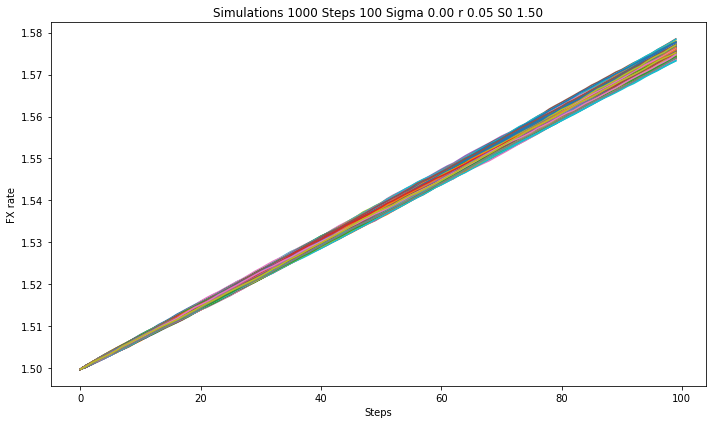

In [222]:
r = 0.05 #risk-free interest rate
sigma = df['R_log'].std() #volatility in market
T = 1 #time in years
N = 100 #number of steps within each simulation
deltat = T/N #time step
i = 1000 #number of simulations
discount_factor = np.exp(-r*T) #discount factor

S = np.zeros([i,N])
t = range(0,N,1)

# st
plt.figure(figsize=(10,6), tight_layout=True)
for y in range(0,i-1):
    S[y,0]=S0
    for x in range(0,N-1):
        S[y,x+1] = S[y,x]*(np.exp((r-(sigma**2)/2)*deltat + sigma*deltat*np.random.normal(0,1)))
    plt.plot(t,S[y])

plt.title('Simulations %d Steps %d Sigma %.2f r %.2f S0 %.2f' % (i, N, sigma, r, S0))
plt.xlabel('Steps')
plt.ylabel('FX rate')
plt.show()

